In [36]:
import re 
import numpy as np 
import json
from collections import defaultdict 

In [47]:
def read_file(path):
    data_by_src = defaultdict(list)
    with open(path, "r") as f1:
        for line in f1:
            line = json.loads(line)
            # trim off last token (EOS)
            line['logit_at_label'] = np.array(line['logit_at_label'][0:-1])
            data_by_src[line['natural']].append(line)

    # for src, list_ in data_by_src.items():
        # assert(len(list_) == 2)

    return data_by_src

def process_prompt(prompt_text):
    test_idx = re.search("Current test index: (\d+)", prompt_text)
    test_idx = int(test_idx.group(1))

    split_lines = prompt_text.split("\n")
    computer_lines = [x for x in split_lines if x.startswith("Computer:")][0:10]
    prompt_lfs = [re.split("Computer: ", x)[1] for x in computer_lines]

    human_lines = [x for x in split_lines if x.startswith("Human:")]
    human_prompt = re.split("Human: ", human_lines[-1])[1].strip()

    # lf 1 starts with forall, lf 0 starts with exists 
    lf_1_positions = [i for i, x in enumerate(prompt_lfs) if x.startswith("exists")]  

    last_prompt_type = 0 if prompt_lfs[-1].startswith("exists") else 1


    return human_prompt, np.mean(lf_1_positions), last_prompt_type

def parse_stdout(path):
    avg_lf_positions = {}
    last_prompt_types = {}
    with open(path) as f1:
        data = f1.read()

    split_prompts = re.split(r"^Prompt prefix:.*$", data, flags=re.MULTILINE)[1:]
    # scope is 300:400
    for prompt in split_prompts[300:400]:

        src_str, lf_position, last_prompt_type = process_prompt(prompt)
        avg_lf_positions[src_str] = lf_position
        last_prompt_types[src_str] = last_prompt_type
    return avg_lf_positions, last_prompt_types


In [48]:
avg_lf_positions, last_prompt_types = parse_stdout("/brtx/602-nvme1/estengel/ambiguous_parsing/logs/1.0/codegen-350M_lamp_no_context_all_50-50-5k-train-100-perc-ambig_fol_fewshot_2_test_eval_constrained_bs_5_np_10/stdout.20230417T125359")


In [39]:
print(len(avg_lf_positions))

100


In [88]:



model = "codegen-16B"
s1 = 80
s2 = 100-s1

data_for_df = []
path = f"/brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/{model}/{s1}-{s2}-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits"
mins_by_lf = defaultdict(list)
print(f"reading {path}")
try:
    data_by_src = read_file(path)
except FileNotFoundError:
    print(f"file not found: {path}")

for i, (src, lines) in enumerate(data_by_src.items()):
    try:
        avg_lf_pos = avg_lf_positions[src]
        last_prompt_type = last_prompt_types[src]
    except KeyError:
        continue

    p_lf0, p_lf1 = None, None
    min_lf0, min_lf1 = None, None
    for line in lines:
        template_idx = str(line['template_idx'])
        total_prob = np.exp(np.sum(np.log(line['logit_at_label'])))

        min_logit_at_label = np.min(line['logit_at_label']) 
        if template_idx == '0':
            min_lf0 = min_logit_at_label
            p_lf0 = total_prob
        else:
            min_lf1 = min_logit_at_label
            p_lf1 = total_prob

    # turn into a proper probability by normalizing 
    norm_min_p_lf0 = min_lf0 / (min_lf0 + min_lf1)
    norm_total_p_lf0 = p_lf0 / (p_lf0 + p_lf1)

    data_for_df.append({"model": model, "s1": s1/100, "s2": s2/100, "last_prompt_type": last_prompt_type, "avg_lf_pos": avg_lf_pos, "type": "norm_min_lf0", "value": norm_min_p_lf0}) 
    data_for_df.append({"model": model, "s1": s1/100, "s2": s2/100, "last_prompt_type": last_prompt_type, "avg_lf_pos": avg_lf_pos, "type": "norm_total_lf0", "value": norm_total_p_lf0}) 



reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-16B/80-20-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits


0.008309544814919035


Text(0.5, 1.0, 'codegen-16B - 80-20')

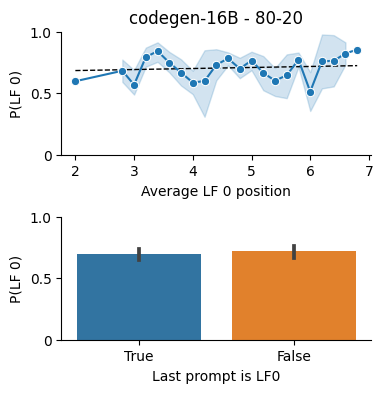

In [89]:
import seaborn as sns
from matplotlib import pyplot as plt 
import pandas as pd
from sklearn.linear_model import LinearRegression

df = pd.DataFrame(data_for_df)


##  Normalized minimum probability
norm_df = df[df['type'] == "norm_min_lf0"]


# increase vertical spacing between subplots
fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5})
# plot best fit line
reg = LinearRegression().fit(norm_df[['avg_lf_pos']], norm_df['value'])
slope, intercept = reg.coef_[0], reg.intercept_
print(slope)
x = np.linspace(norm_df[['avg_lf_pos']].min(), norm_df[['avg_lf_pos']].max(), 100)
ax[0].plot(x, slope*x + intercept, color='black', linestyle='--', linewidth=1)


sns.lineplot(data = norm_df, x="avg_lf_pos", y="value", ax=ax[0],  marker = "o")
ax[0].set_xlabel("Average LF 0 position")
ax[0].set_ylabel("P(LF 0)")
ax[0].set_yticks([0, 0.5, 1.0])
ax[0].set_ylim(0,1)
ax[0].set_yticklabels([0, 0.5, 1.0])


sns.barplot(data = norm_df, x="last_prompt_type", y="value", ax=ax[1])
ax[1].set_yticks([0, 0.5, 1.0])
ax[1].set_ylim(0,1)
ax[1].set_yticklabels([0, 0.5, 1.0])
ax[1].set_xlabel("Last prompt is LF0")
ax[1].set_xticklabels(["True", "False"])
ax[1].set_ylabel("P(LF 0)")
sns.despine()

ax[0].set_title(f"{model} - {s1}-{s2}")